<div align="right"><b>Бронников Егор ПМ-1901</b></p>

# <center>Построение простейших моделей прогнозирования</center>

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

Загрузим и отобразим данные об объемах пассажирских авиаперевозок.

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

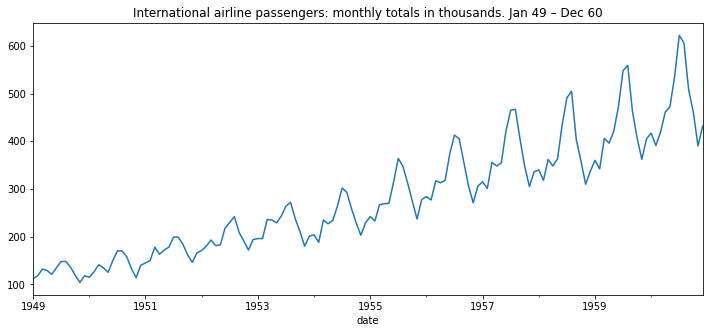

In [3]:
passengers['num_passengers'].plot(figsize=(12,5))
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 60')
plt.show()

Временной ряд обладает трендом и годовой сезонностью, которые должны быть учтены при построении моделей прогнозирования. Наличие тренда и сезонности проявляется на коррелограмме. Для построения коррелограммы воспользуемся функцией `plot_acf` из библиотеки `statsmodels`.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

Опция `lags` позволяет задавать количество лагов для вычисления значений автокорреляции.

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(passengers['num_passengers'], lags=40, ax=ax)
plt.show()

<div class="alert alert-info">

<h3> Задание 1</h3>
<p></p>
Постройте наивную сезонную модель прогнозирования. Данная модель предполагает, что количество пассажиров в январе 1961 г. будет таким же, как и в январе 1960 г. С помощью полученной модели получите прогноз на 3 года вперед и отобразите результат на графике.
<p></p>
  
</div>

In [ ]:
naivpass = passengers.copy()

In [ ]:
for year in range(1961,1964):
    last = naivpass['num_passengers'][-12:]
    for i in range(0,12):
        naivpass = pd.concat([naivpass, pd.DataFrame({'num_passengers': last[i]}, index=[pd.Timestamp(datetime.date(year, i+1, 1))])])

In [ ]:
naivpass[-12:]

In [ ]:
figure(figsize=(12,5))
plt.plot(naivpass['num_passengers'])
plt.plot(passengers['num_passengers'])
plt.title('Naive forecasting')
plt.show()

<div class="alert alert-info">

<h3> Задание 2</h3>
<p></p>
Наивная сезонная модель прогнозирования не учитывает тренд временного ряда. Воспользуйтесь методом экстраполяции тренда, постройте прогноз также на 3 года и отобразите результат на графике.
    
<em>Комментарий: пока реализуйте только метод экстраполяции тренда! Не спешите объединять модели.</em>
<p></p>
  
</div>

In [ ]:
extrpass = passengers.copy()

In [ ]:
first = passengers['num_passengers'][0]
last = passengers['num_passengers'][-1]
T = len(passengers)
indices = pd.date_range(start='1949-01-01', end='1960-12-01', freq = 'MS')
previous = pd.DataFrame(
                        (np.arange(0,T,1)/T)*(last - first) + first,
                        index = indices,
                        columns = ['num_passengers']
                        )

In [ ]:
extrpass.loc[indices,'num_passengers'] = previous

In [ ]:
h = 1
last = extrpass['num_passengers'][-1]
first = extrpass['num_passengers'][0]
T = len(extrpass)
for year in range(1961,1964):
    for i in range(0,12):
        h += 1
        next_ = last + h*(last - first)/(T-1)
        extrpass = pd.concat([extrpass, pd.DataFrame({'num_passengers': next_}, index=[pd.Timestamp(datetime.date(year, i+1, 1))])])

In [ ]:
extrpass[-12:]

In [ ]:
figure(figsize=(12,5))
plt.plot(extrpass['num_passengers'])
plt.plot(passengers['num_passengers'])
plt.title('Trend extrapolation forecasting')
plt.show()

<div class="alert alert-info">

<h3> Задание 3</h3>
<p></p>
В результате выполнения предыдущих заданий вы получили две модели, каждая из которых описывает только одну из компонент ряда: либо тренд, либо сезонность. Попробуем их объединить. Для этого:
    <p></p>
    <li>вычтите из исходного ряда трендовую составляющую, постройте коррелограмму полученного ряда остатков;</li>
    <li>для ряда остатков постройте наивную сезонную модель.</li>
    
 Получите прогноз на 3 года вперед с помощью комбинации моделей. Результат отобразите на графике.
<p></p>
  
</div>

In [ ]:
rem = passengers - extrpass[:-36]
rem.tail()

In [ ]:
figure(figsize=(12,5))
plt.plot(rem['num_passengers'])
plt.title('Row of remnants')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(rem['num_passengers'], lags=40, ax=ax)
plt.show()

In [ ]:
naivpassrem = rem.copy()

In [ ]:
for year in range(1961,1964):
    last = naivpassrem['num_passengers'][-12:]
    for i in range(0,12):
        naivpassrem = pd.concat([naivpassrem, pd.DataFrame({'num_passengers': last[i]}, index=[pd.Timestamp(datetime.date(year, i+1, 1))])])

In [ ]:
naivpassrem[-12:]

In [ ]:
figure(figsize=(12,5))
plt.plot(naivpassrem['num_passengers'])
plt.plot(rem['num_passengers'])
plt.title('Naive forecasting for row of remnants')
plt.show()

In [ ]:
res = naivpassrem + extrpass
res[-12:]

In [ ]:
figure(figsize=(12,5))
plt.plot(res['num_passengers'])
plt.plot(passengers['num_passengers'])
plt.title('Naive + trend extrapolation forecasting')
plt.show()

### Мультипликативная сезонность

Во временном ряду пассажирских авиаперевозок наблюдается **мультипликативная сезонность**, которая характеризуется увеличением амплитуды сезонных колебаний. В случае когда амплитуда сезонных колебаний не меняется, говорят об **аддитивной сезонности**.

Ряд с трендом и аддитивной сезонностью может быть представлен в виде суммы его компонент:

$$y(t)=b(t)+s(t)+\epsilon(t),$$

где $b(t)$ &ndash; трендовая, $s(t)$ &ndash; сезонная, а $\epsilon(t)$ &ndash; случайная компоненты ряда.

Ряд с мультипликативной сезонностью представляет собой произведение данных компонент:

$$y(t)=b(t)\times s(t)\times \epsilon(t).$$

<div class="alert alert-info">

<h3> Задание 4</h3>
<p></p>
Постройте мультипликативную модель прогнозирования, получите прогноз на 3 года вперед и отобразите результат на графике. Также, для сравнения, отобразите на графике прогноз модели из предыдущего задания.
<p></p>
  
</div>